# Inerpretation-Net Training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes

config = {
    'data': {
        'd': 3, #degree
        'n': 15, #number of variables
        'monomial_vars': None, #int or None
        'laurent': False, #use Laurent polynomials (negative degree with up to -d)  
        'neg_d': 0,#int or None
        'neg_d_prob': 0,
        'sparsity': None,
        'sample_sparsity': 15,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 1000,
        'noise': 0,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'border_min': 0.2, #needs to be between 0 and (x_max-x_min)/2
        'border_max': 0.4,
        'lower_degree_prob': 0.5,
        'a_zero_prob': 0.25,
        'a_random_prob': 0.1,      
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'early_stopping_min_delta_lambda': 1e-4,
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sample_sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 5000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0.25,
        'dropout_output': 0,
        'epochs': 100, 
        'early_stopping': True,
        'batch_size': 256,
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 1000,
                
        'interpretation_net_output_monomials': 15, #(None, int) #CONSTANT IS NOT INCLUDED
        'interpretation_net_output_shape': None, #calculated automatically later
        'test_size': 100, #Float for fraction, Int for number 0
        
        'normalize_inet_data': False,
        'inet_training_without_noise': True, #dataset size without noise hardcoded to 50k in generate_paths
        'sparse_poly_representation_version': 1, #(1, 2); 1=old, 2=new

        'evaluate_with_real_function': False, #False
        'consider_labels_training': False, #False
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 100,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 100,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
        'per_network_optimization_dataset_size': 5000,
        
        'adjusted_symbolic_metamodeling_code': False,
        'symbolic_metamodeling_evaluation': False,
        'symbolic_metamodeling_poly_evaluation': False,
        'symbolic_metamodeling_function_evaluation': False,
        'symbolic_metamodeling_poly_function_evaluation': False,
        
        
        'symbolic_regression_evaluation': False,
        'per_network_evaluation': False,
    },
    'computation':{
        'train_model': True,
        'n_jobs': 10,
        'use_gpu': True,
        'gpu_numbers': '2',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score

from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import tensorflow as tf
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


import tensorflow.keras.backend as K
from livelossplot import PlotLossesKerasTF
#from keras_tqdm import TQDMNotebookCallback

from matplotlib import pyplot as plt
import seaborn as sns


import random 


import warnings

from IPython.display import Image
from IPython.display import display, Math, Latex, clear_output



In [4]:
tf.__version__

'2.4.1'

In [5]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

data_reshape_version = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
#os.environ['XLA_FLAGS'] =  '--xla_gpu_cuda_data_dir=/usr/lib/cuda-10.1'

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

sys.path.append('..')

In [6]:
from utilities.utility_functions import flatten, rec_gen, gen_monomial_identifier_list

list_of_monomial_identifiers_extended = []

if laurent:
    variable_sets = [list(flatten([[_d for _d in range(d+1)], [-_d for _d in range(1, neg_d+1)]])) for _ in range(n)]
    list_of_monomial_identifiers_extended = rec_gen(variable_sets)    
        
    print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
    #print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
    #print('Sparsity:' + str(sparsity))
    if len(list_of_monomial_identifiers_extended) < 500:
        print(list_of_monomial_identifiers_extended)     
        
    list_of_monomial_identifiers = []
    for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
        if np.sum(monomial_identifier) <= d:
            if monomial_vars == None or len(list(filter(lambda x: x != 0, monomial_identifier))) <= monomial_vars:
                list_of_monomial_identifiers.append(monomial_identifier)        
else:
    variable_list = ['x'+ str(i) for i in range(n)]
    list_of_monomial_identifiers = gen_monomial_identifier_list(variable_list, d, n)
            
print('List length: ' + str(len(list_of_monomial_identifiers)))
#print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
#print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


List length: 816
[[3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In [7]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis
config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda
config['i_net']['data_reshape_version'] = data_reshape_version

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d']) if not laurent else len(list_of_monomial_identifiers)
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else config['data']['sparsity']*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials'] if config['i_net']['sparse_poly_representation_version'] == 1 else config['data']['n']*(config['data']['d']+1)*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials']  
print('Output Shape: ', config['i_net']['interpretation_net_output_shape'])

transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sample_sparsity')*config['data']['sample_sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

Output Shape:  12255


In [8]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense512-1024-output_12255_drop0.25e100b256_custom/lnets_1000_75-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_15_d_3_negd_0_prob_0_spars_15_amin_-1_amax_1_xdist_uniform_noise_normal_0bmin0.2bmax0.4lowd0.5azero0.25arand0.1
lnets_1000_75-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_15_d_3_negd_0_prob_0_spars_15_amin_-1_amax_1_xdist_uniform_noise_normal_0bmin0.2bmax0.4lowd0.5azero0.25arand0.1


In [9]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  1
Num XLA-GPUs Available:  0


## Load Data and Generate Datasets

In [10]:
def load_lambda_nets(index, no_noise=False):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path_identifier_lambda_net_data_loading = None 
                
    if no_noise==True:
        path_identifier_lambda_net_data_loading = generate_paths(path_type='interpretation_net_no_noise')['path_identifier_lambda_net_data']
    else:
        path_identifier_lambda_net_data_loading = path_identifier_lambda_net_data 
        
    directory = './data/weights/' + 'weights_' + path_identifier_lambda_net_data_loading + '/'
    path_weights = directory + 'weights_epoch_' + str(index).zfill(3) + '.txt'
    path_X_data = directory + 'lambda_X_test_data.txt'
    path_y_data = directory + 'lambda_y_test_data.txt'        
    
    weight_data = pd.read_csv(path_weights, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_X_test_data = pd.read_csv(path_X_data, sep=",", header=None)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
    
    lambda_y_test_data = pd.read_csv(path_y_data, sep=",", header=None)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    if no_noise == False:
        lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)
        
    lambda_nets = [None] * weight_data.shape[0]
    for i, (row_weights, row_lambda_X_test_data, row_lambda_y_test_data) in enumerate(zip(weight_data.values, lambda_X_test_data.values, lambda_y_test_data.values)):        
        lambda_net = LambdaNet(row_weights, row_lambda_X_test_data, row_lambda_y_test_data)
        lambda_nets[i] = lambda_net
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [11]:
#LOAD DATA
if inet_training_without_noise:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list_without_noise = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1, no_noise=True) for i in epochs_save_range_lambda)  
    del parallel
    
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel
else:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
    lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
    del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=10)]: Using backend MultiprocessingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed: 13.9min finished
[Parallel(n_jobs=10)]: Using backend MultiprocessingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   21.7s finished


## Data Inspection

In [12]:
lambda_net_dataset.as_pandas().head()

seed  300000000000000-target  210000000000000-target  \
521  1373158606                   0.000                   0.000   
737  1373158606                   0.000                   0.000   
740  1373158606                   0.000                   0.000   
660  1373158606                   0.000                   0.000   
411  1373158606                   0.000                   0.000   

     201000000000000-target  200100000000000-target  200010000000000-target  \
521                   0.000                   0.000                   0.000   
737                   0.000                   0.000                   0.000   
740                   0.000                   0.000                   0.000   
660                   0.000                   0.000                   0.000   
411                   0.000                   0.000                   0.000   

     200001000000000-target  200000100000000-target  200000010000000-target  \
521                   0.000                   0.000                   0.000   
737                   0.000                   0.000                   0.000   
740                   0.000                   0.000                   0.000   
660                   0.000                   0.000                   0.000   
411                   0.000                   0.000                   0.000   

     200000001000000-target  200000000100000-target  200000000010000-target  \
521                   0.000                   0.000                   0.000   
737                   0.000                   0.000                   0.000   
740                   0.000                   0.000                   0.000   
660                   0.000                   0.000                   0.000   
411                   0.000                   0.000                   0.000   

     200000000001000-target  200000000000100-target  200000000000010-target  \
521                   0.000                   0.000                   0.000   
737                   0.000                   0.000                   0.000   
740                   0.000                   0.000                   0.000   
660                   0.000                   0.000                   0.000   
411                   0.000                   0.000                   0.000   

     200000000000001-target  200000000000000-target  120000000000000-target  \
521                   0.000                   0.000                   0.000   
737                   0.000                   0.000                   0.000   
740                   0.000                   0.000                   0.000   
660                   0.000                   0.000                   0.000   
411                   0.000                   0.000                  -0.295   

     111000000000000-target  110100000000000-target  110010000000000-target  \
521                   0.000                   0.000                   0.000   
737                   0.000                   0.000                   0.000   
740                   0.000                   0.000                   0.000   
660                   0.000                   0.000                   0.000   
411                   0.000                   0.000                   0.000   

     110001000000000-target  110000100000000-target  110000010000000-target  \
521                   0.000                   0.000                   0.000   
737                   0.000                   0.000                   0.000   
740                   0.000                   0.000                   0.000   
660                   0.000                   0.000                   0.000   
411                   0.000                   0.000                   0.000   

     110000001000000-target  110000000100000-target  110000000010000-target  \
521                   0.000                  -0.037                   0.000   
737                   0.000                   0.000                   0.000   
740                   0.000                   

In [13]:
lambda_net_dataset.as_pandas().describe()

seed  300000000000000-target  210000000000000-target  \
count       1000.000                1000.000                1000.000   
mean  1373158606.000                  -0.002                   0.000   
std            0.000                   0.052                   0.096   
min   1373158606.000                  -0.874                  -0.916   
25%   1373158606.000                   0.000                   0.000   
50%   1373158606.000                   0.000                   0.000   
75%   1373158606.000                   0.000                   0.000   
max   1373158606.000                   0.515                   0.927   

       201000000000000-target  200100000000000-target  200010000000000-target  \
count                1000.000                1000.000                1000.000   
mean                   -0.002                  -0.001                  -0.002   
std                     0.057                   0.070                   0.088   
min                    -0.810                  -0.870                  -0.993   
25%                     0.000                   0.000                   0.000   
50%                     0.000                   0.000                   0.000   
75%                     0.000                   0.000                   0.000   
max                     0.934                   0.825                   0.861   

       200001000000000-target  200000100000000-target  200000010000000-target  \
count                1000.000                1000.000                1000.000   
mean                    0.003                  -0.003                   0.004   
std                     0.062                   0.078                   0.077   
min                    -0.955                  -0.920                  -0.936   
25%                     0.000                   0.000                   0.000   
50%                     0.000                   0.000                   0.000   
75%                     0.000                   0.000                   0.000   
max                     0.855                   0.882                   0.819   

       200000001000000-target  200000000100000-target  200000000010000-target  \
count                1000.000                1000.000                1000.000   
mean                    0.006                  -0.004                   0.001   
std                     0.083                   0.061                   0.081   
min                    -0.810                  -0.982                  -0.981   
25%                     0.000                   0.000                   0.000   
50%                     0.000                   0.000                   0.000   
75%                     0.000                   0.000                   0.000   
max                     0.976                   0.554                   0.986   

       200000000001000-target  200000000000100-target  200000000000010-target  \
count                1000.000                1000.000                1000.000   
mean                    0.000                  -0.002                   0.004   
std                     0.073                   0.075                   0.054   
min                    -0.836                  -0.940                  -0.256   
25%                     0.000                   0.000                   0.000   
50%                     0.000                   0.000                   0.000   
75%                     0.000                   0.000                   0.000   
max                     0.927                   0.861                   0.886   

       200000000000001-target  200000000000000-target  120000000000000-target  \
count                1000.000                1000.000                1000.000   
mean                   -0.004                  -0.002                  -0.002   
std                     0.071                   0.085                   0.102   
min                    -0.985                  -0.989                  -0.886   
25%                     0.000             

In [14]:
lambda_net_dataset.X_test_data_list[0][:10]

array([[0.77429818, 0.37601534, 0.85581126, 0.79624257, 0.65766329,
        0.11699013, 0.38575347, 0.11054977, 0.38181685, 0.51500029,
        0.55268317, 0.10597138, 0.87408762, 0.62802106, 0.29803501],
       [0.87618229, 0.07804635, 0.08146732, 0.3678029 , 0.96537907,
        0.40028196, 0.07410265, 0.78097622, 0.40059963, 0.62740278,
        0.59316296, 0.23893021, 0.56729737, 0.49389666, 0.32207199],
       [0.38630956, 0.03700988, 0.74940169, 0.17312311, 0.68556537,
        0.34016381, 0.52379265, 0.21407495, 0.4586261 , 0.99436764,
        0.41815319, 0.66961298, 0.59049174, 0.50574352, 0.48653456],
       [0.75892108, 0.53021674, 0.05324119, 0.13208294, 0.51441945,
        0.93792792, 0.13756213, 0.02458072, 0.60262112, 0.36662522,
        0.82611129, 0.29742438, 0.17042853, 0.52236138, 0.19739011],
       [0.57358834, 0.72206484, 0.35192964, 0.73452616, 0.46707291,
        0.47340715, 0.26474251, 0.26233106, 0.40600132, 0.83619531,
        0.35432833, 0.66367872, 0.75923185, 

In [15]:
lambda_net_dataset.y_test_data_list[0][:10]

array([[-0.07482722],
       [-0.30516753],
       [-0.22043148],
       [ 0.03952776],
       [-0.58250761],
       [-0.61602485],
       [-0.76654756],
       [ 0.19481882],
       [-0.63770199],
       [-0.03827422]])

## Generate Datasets for Interpretation-Net training

In [16]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []


if inet_training_without_noise:
   
    for lambda_net_dataset, lambda_net_dataset_without_noise in zip(lambda_net_dataset_list, lambda_net_dataset_list_without_noise):
        if inet_holdout_seed_evaluation:
            raise SystemExit('Holdout Evaluation not implemented with inet training without noise')
            
        else:
            lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_dataset_without_noise, test_split=0.1)

            _, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset, lambda_net_dataset_list_without_noise
        
else:

    for lambda_net_dataset in lambda_net_dataset_list:

        if inet_holdout_seed_evaluation:

            complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

            random.seed(RANDOM_SEED)

            if isinstance(test_size, float):
                test_size = int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-test_size)))

            test_seeds = random.sample(complete_seed_list, test_size)
            lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
            complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)

            random.seed(RANDOM_SEED)
            valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/(1-0.1))))
            lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
            complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

            train_seeds = complete_seed_list
            lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset
        else:

            lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
            lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

            lambda_net_train_dataset_list.append(lambda_net_train_dataset)
            lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
            lambda_net_test_dataset_list.append(lambda_net_test_dataset)

            del lambda_net_dataset, lambda_net_train_with_valid_dataset


del lambda_net_dataset_list

In [17]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(45000, 3725)

In [18]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(5000, 3725)

In [19]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(100, 3725)

In [20]:
lambda_net_train_dataset_list[-1].as_pandas().head()

seed  300000000000000-target  210000000000000-target  \
15722  1373158606                   0.000                   0.000   
49742  1373158606                   0.200                   0.000   
15559  1373158606                   0.000                   0.000   
37857  1373158606                   0.000                   0.000   
35691  1373158606                   0.000                   0.000   

       201000000000000-target  200100000000000-target  200010000000000-target  \
15722                   0.000                   0.000                   0.000   
49742                   0.000                   0.000                   0.000   
15559                   0.000                   0.000                   0.000   
37857                   0.000                   0.000                   0.000   
35691                   0.000                   0.000                   0.000   

       200001000000000-target  200000100000000-target  200000010000000-target  \
15722                   0.000                   0.000                   0.000   
49742                   0.000                   0.000                   0.000   
15559                   0.000                   0.000                   0.000   
37857                   0.000                   0.000                   0.000   
35691                   0.000                   0.000                   0.000   

       200000001000000-target  200000000100000-target  200000000010000-target  \
15722                   0.000                   0.000                   0.000   
49742                   0.000                   0.000                   0.000   
15559                   0.000                   0.000                   0.000   
37857                   0.000                   0.000                   0.000   
35691                   0.000                   0.000                   0.000   

       200000000001000-target  200000000000100-target  200000000000010-target  \
15722                   0.000                   0.000                   0.000   
49742                   0.000                   0.000                   0.000   
15559                   0.000                   0.000                   0.000   
37857                   0.000                   0.000                   0.000   
35691                   0.000                   0.000                   0.000   

       200000000000001-target  200000000000000-target  120000000000000-target  \
15722                   0.000                   0.000                   0.000   
49742                   0.000                   0.000                   0.000   
15559                   0.000                   0.000                   0.000   
37857                   0.000                   0.000                   0.000   
35691                   0.000                   0.000                   0.000   

       111000000000000-target  110100000000000-target  110010000000000-target  \
15722                   0.000                   0.000                   0.000   
49742                   0.000                   0.000                   0.000   
15559                   0.036                   0.000                   0.000   
37857                   0.000                   0.000                   0.000   
35691                   0.000                   0.000                   0.000   

       110001000000000-target  110000100000000-target  110000010000000-target  \
15722                   0.000                   0.000                   0.000   
49742                   0.000                   0.000                   0.000   
15559                   0.000                   0.000                   0.000   
37857                   0.000                   0.000                   0.000   
35691                   0.000                   0.000                   0.000   

       110000001000000-target  110000000100000-target  110000000010000-target  \
15722                   0.000                   0.000                   0.000   
49742                   0.0

In [21]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

seed  300000000000000-target  210000000000000-target  \
35587  1373158606                   0.000                   0.000   
32681  1373158606                   0.134                   0.000   
40971  1373158606                   0.000                   0.000   
21022  1373158606                   0.000                   0.000   
6403   1373158606                   0.000                   0.000   

       201000000000000-target  200100000000000-target  200010000000000-target  \
35587                   0.000                   0.000                   0.000   
32681                   0.000                   0.000                   0.000   
40971                   0.000                   0.000                   0.000   
21022                   0.000                   0.000                   0.000   
6403                    0.000                   0.000                   0.000   

       200001000000000-target  200000100000000-target  200000010000000-target  \
35587                   0.000                   0.000                   0.000   
32681                   0.000                   0.000                   0.000   
40971                  -0.966                   0.000                   0.000   
21022                   0.000                   0.000                   0.000   
6403                    0.649                   0.000                   0.000   

       200000001000000-target  200000000100000-target  200000000010000-target  \
35587                   0.000                   0.000                   0.000   
32681                   0.000                   0.000                   0.000   
40971                   0.000                   0.000                   0.000   
21022                   0.000                   0.000                   0.000   
6403                    0.000                   0.000                   0.000   

       200000000001000-target  200000000000100-target  200000000000010-target  \
35587                   0.000                   0.000                   0.000   
32681                   0.000                   0.000                   0.000   
40971                   0.000                   0.000                   0.000   
21022                   0.000                   0.000                   0.000   
6403                    0.000                   0.000                   0.000   

       200000000000001-target  200000000000000-target  120000000000000-target  \
35587                   0.000                   0.000                   0.000   
32681                   0.000                   0.000                   0.000   
40971                   0.000                   0.000                   0.000   
21022                   0.000                   0.000                   0.000   
6403                    0.000                   0.000                   0.000   

       111000000000000-target  110100000000000-target  110010000000000-target  \
35587                   0.000                   0.000                   0.000   
32681                   0.000                   0.000                   0.000   
40971                   0.000                   0.000                   0.000   
21022                   0.000                   0.000                   0.000   
6403                    0.000                   0.000                   0.000   

       110001000000000-target  110000100000000-target  110000010000000-target  \
35587                   0.000                   0.000                   0.000   
32681                   0.000                   0.000                   0.000   
40971                   0.000                   0.000                   0.000   
21022                   0.000                   0.000                   0.000   
6403                    0.000                   0.000                   0.000   

       110000001000000-target  110000000100000-target  110000000010000-target  \
35587                   0.000                   0.000                   0.000   
32681                   0.0

In [22]:
lambda_net_test_dataset_list[-1].as_pandas().head()

seed  300000000000000-target  210000000000000-target  \
666  1373158606                   0.000                   0.000   
129  1373158606                   0.000                   0.000   
784  1373158606                   0.000                   0.000   
152  1373158606                   0.000                   0.000   
920  1373158606                   0.000                   0.000   

     201000000000000-target  200100000000000-target  200010000000000-target  \
666                   0.000                   0.000                   0.000   
129                   0.000                   0.000                   0.000   
784                   0.000                   0.000                   0.000   
152                   0.000                   0.000                   0.000   
920                   0.000                   0.000                   0.000   

     200001000000000-target  200000100000000-target  200000010000000-target  \
666                   0.000                   0.000                   0.000   
129                   0.000                   0.000                   0.150   
784                   0.000                   0.000                   0.000   
152                   0.000                   0.000                  -0.394   
920                   0.000                   0.000                   0.000   

     200000001000000-target  200000000100000-target  200000000010000-target  \
666                   0.000                   0.000                   0.000   
129                   0.000                   0.000                   0.000   
784                   0.000                   0.000                   0.000   
152                   0.000                   0.000                   0.000   
920                   0.000                   0.000                   0.000   

     200000000001000-target  200000000000100-target  200000000000010-target  \
666                   0.000                   0.000                   0.000   
129                   0.000                   0.000                   0.000   
784                   0.000                   0.000                   0.000   
152                   0.000                   0.000                   0.000   
920                   0.000                   0.000                   0.000   

     200000000000001-target  200000000000000-target  120000000000000-target  \
666                   0.000                   0.000                   0.000   
129                   0.000                   0.000                   0.000   
784                   0.000                   0.000                   0.000   
152                   0.000                   0.000                   0.000   
920                   0.000                   0.000                   0.000   

     111000000000000-target  110100000000000-target  110010000000000-target  \
666                   0.000                   0.000                   0.000   
129                   0.000                   0.000                   0.000   
784                   0.000                   0.000                   0.000   
152                   0.000                   0.000                   0.000   
920                   0.000                   0.000                   0.000   

     110001000000000-target  110000100000000-target  110000010000000-target  \
666                   0.000                   0.000                   0.000   
129                  -0.259                   0.000                   0.000   
784                   0.000                   0.000                   0.000   
152                  -0.195                   0.000                   0.000   
920                   0.000                   0.000                   0.000   

     110000001000000-target  110000000100000-target  110000000010000-target  \
666                   0.000                   0.000                   0.000   
129                   0.000                   0.000                   0.000   
784                   0.000                   

## Interpretation Network Training

In [23]:
#%load_ext autoreload

----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------
Epoch 1/100
176/176 [==============================] - 118s 628ms/step - loss: 0.3607 - r2_inet_lambda_fv_loss: 0.4508 - val_loss: 0.3110 - val_r2_inet_lambda_fv_loss: 0.0786
Epoch 2/100
176/176 [==============================] - 108s 613ms/step - loss: 0.3149 - r2_inet_lambda_fv_loss: 0.0944 - val_loss: 0.3054 - val_r2_inet_lambda_fv_loss: 0.0370
Epoch 3/100
176/176 [==============================] - 107s 608ms/step - loss: 0.3104 - r2_inet_lambda_fv_loss: 0.0619 - val_loss: 0.3036 - val_r2_inet_lambda_fv_loss: 0.0219
Epoch 4/100
176/176 [==============================] - 106s 605ms/step - loss: 0.3084 - r2_inet_lambda_fv_loss: 0.0437 - val_loss: 0.3021 - val_r2_inet_lambda_fv_loss: 0.0128
Epoch 5/100
176/176 [==============================] - 106s 604ms/step - loss: 0.3056 - r2_inet_lambda_fv_loss: 0.0288 - val_loss: 0.3004 - val_r2_inet_lambda_fv_loss: 0.0014
E

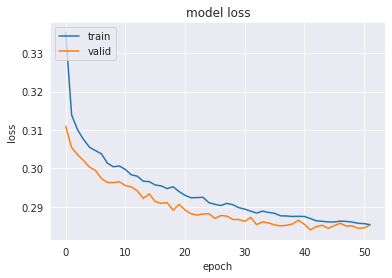

In [24]:
#%autoreload 2
((X_valid_list, y_valid_list), 
 (X_test_list, y_test_list),
 history_list, 

 #scores_valid_list,
 #scores_test_list, 

 #function_values_valid_list, 
 #function_values_test_list, 

 #polynomial_dict_valid_list,
 #polynomial_dict_test_list,

 #distrib_dict_valid_list,
 #distrib_dict_test_list,

 model_list) = interpretation_net_training(lambda_net_train_dataset_list, 
                                           lambda_net_valid_dataset_list, 
                                           lambda_net_test_dataset_list)



In [25]:
#polynomial_dict_valid_list = []
polynomial_dict_test_list = []  


for lambda_net_valid_dataset, lambda_net_test_dataset in zip(lambda_net_valid_dataset_list, lambda_net_test_dataset_list):

    #polynomial_dict_valid = {'lstsq_lambda_pred_polynomials': lambda_net_valid_dataset.lstsq_lambda_pred_polynomial_list,
    #                        'lstsq_target_polynomials': lambda_net_valid_dataset.lstsq_target_polynomial_list,
    #                        'target_polynomials': lambda_net_valid_dataset.target_polynomial_list}    

    polynomial_dict_test = {'lstsq_lambda_pred_polynomials': lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list,
                            'lstsq_target_polynomials': lambda_net_test_dataset.lstsq_target_polynomial_list,
                            'target_polynomials': lambda_net_test_dataset.target_polynomial_list}    

    #polynomial_dict_valid_list.append(polynomial_dict_valid)  
    polynomial_dict_test_list.append(polynomial_dict_test)


In [26]:
print('---------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------- PREDICT INET ------------------------------------------------------')

start = time.time() 

for i, (X_test, model) in enumerate(zip(X_test_list, model_list)):
    #y_test_pred = model.predict(X_test)    
    #print(model.summary())
    #print(X_test.shape)
    y_test_pred = make_inet_prediction(model, X_test, network_data=None, lambda_trained_normalized=False, inet_training_normalized=normalize_inet_data, normalization_parameter_dict=None)
    #print(y_test_pred.shape)   
    polynomial_dict_test_list[i]['inet_polynomials'] = y_test_pred


end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('Predict Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')

---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------- PREDICT INET ------------------------------------------------------
Predict Time: 0:00:00
---------------------------------------------------------------------------------------------------------------------------


In [27]:
if symbolic_metamodeling_poly_evaluation:
    print('-------------------------------------------------- CALCULATE METAMODEL POLY -----------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        
        metamodel_functions_test = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=False, force_polynomial=True)
        polynomial_dict_test_list[i]['metamodel_poly'] = metamodel_functions_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Metamodel Poly Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------') 

In [28]:
if symbolic_metamodeling_evaluation:
    print('---------------------------------------------------- CALCULATE METAMODEL --------------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        metamodel_functions_test = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=False, force_polynomial=False)
        polynomial_dict_test_list[i]['metamodel_functions'] = metamodel_functions_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Metamodel Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------') 

In [29]:
if symbolic_metamodeling_function_evaluation:
    print('----------------------------------------------- CALCULATE METAMODEL FUNCTION ----------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        metamodel_functions_test = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=True)
        polynomial_dict_test_list[i]['metamodel_functions_no_GD'] = metamodel_functions_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Metamodel Function Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------') 

In [30]:
if symbolic_regression_evaluation:
    print('----------------------------------------- CALCULATE SYMBOLIC REGRESSION FUNCTION ------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        symbolic_regression_functions_test = symbolic_regression_function_generation(lambda_net_test_dataset)
        polynomial_dict_test_list[i]['symbolic_regression_functions'] = symbolic_regression_functions_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Symbolic Regression Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------')    

In [31]:
#%autoreload 2
if per_network_evaluation:
    print('------------------------------------------------ CALCULATE PER NETWORK POLY -----------------------------------------------')

    start = time.time() 

    for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
        per_network_poly_test = per_network_poly_generation(lambda_net_test_dataset, optimization_type='scipy')
        polynomial_dict_test_list[i]['per_network_polynomials'] = per_network_poly_test       

    end = time.time()     
    inet_train_time = (end - start) 
    minutes, seconds = divmod(int(inet_train_time), 60)
    hours, minutes = divmod(minutes, 60)        
    print('Per Network Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
    print('---------------------------------------------------------------------------------------------------------------------------')

In [32]:
print('------------------------------------------------ CALCULATE FUNCTION VALUES ------------------------------------------------')                

start = time.time() 

function_values_test_list = []
for lambda_net_test_dataset, polynomial_dict_test in zip(lambda_net_test_dataset_list, polynomial_dict_test_list):
    function_values_test = calculate_all_function_values(lambda_net_test_dataset, polynomial_dict_test)
    function_values_test_list.append(function_values_test)

end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('FV Calculation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')

------------------------------------------------ CALCULATE FUNCTION VALUES ------------------------------------------------
True


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


True


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


True


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=10)]: Using backend SequentialBackend with 1 concurrent workers.


False
metamodel_poly
Exit <class 'KeyError'>
metamodel_functions
Exit <class 'KeyError'>
metamodel_functions_no_GD
Exit <class 'KeyError'>
symbolic_regression_functions
Exit <class 'KeyError'>
per_network_polynomials
Exit <class 'KeyError'>
FV Calculation Time: 0:00:16
---------------------------------------------------------------------------------------------------------------------------


[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    2.3s finished


In [33]:
print('----------------------------------------------------- CALCULATE SCORES ----------------------------------------------------')                

start = time.time() 

scores_test_list = []
distrib_dict_test_list = []

for function_values_test, polynomial_dict_test in zip(function_values_test_list, polynomial_dict_test_list):
    scores_test, distrib_test = evaluate_all_predictions(function_values_test, polynomial_dict_test)
    scores_test_list.append(scores_test)
    distrib_dict_test_list.append(distrib_test)

end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('Score Calculation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')
print('---------------------------------------------------------------------------------------------------------------------------')         


----------------------------------------------------- CALCULATE SCORES ----------------------------------------------------
lambda_preds_VS_target_polynomials
lambda_preds_VS_lstsq_lambda_pred_polynomials
lambda_preds_VS_lstsq_target_polynomials
lambda_preds_VS_inet_polynomials
target_polynomials_VS_lstsq_lambda_pred_polynomials
target_polynomials_VS_lstsq_target_polynomials
target_polynomials_VS_inet_polynomials
lstsq_lambda_pred_polynomials_VS_lstsq_target_polynomials
lstsq_lambda_pred_polynomials_VS_inet_polynomials
lstsq_target_polynomials_VS_inet_polynomials
Score Calculation Time: 0:00:01
---------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------


In [34]:
identifier_type = 'epochs' if samples_list == None else 'samples'
save_results(scores_list=scores_test_list, by=identifier_type)

## Evaluate Interpretation Net

In [35]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

In [36]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 1276)]       0                                            
__________________________________________________________________________________________________
hidden1_512 (Dense)             (None, 512)          653824      input[0][0]                      
__________________________________________________________________________________________________
activation1_relu (Activation)   (None, 512)          0           hidden1_512[0][0]                
__________________________________________________________________________________________________
dropout1_0.25 (Dropout)         (None, 512)          0           activation1_relu[0][0]           
______________________________________________________________________________________________

In [37]:
if evaluate_with_real_function:
    keys = ['inetPoly_VS_targetPoly_test', 'perNetworkPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test']
else:
    keys = ['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'perNetworkPoly_VS_predLambda_test', 'perNetworkPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test']

In [38]:
scores_test_list[-1]

MAE  RMSE   MAPE  \
lambda_preds_VS_target_polynomials                   NaN   NaN    NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials        NaN   NaN    NaN   
lambda_preds_VS_lstsq_target_polynomials             NaN   NaN    NaN   
lambda_preds_VS_inet_polynomials                     NaN   NaN    NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.080 0.109  7.408   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000  0.000   
target_polynomials_VS_inet_polynomials             0.138 0.191 13.011   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.080 0.109  2.375   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.153 0.202 43.986   
lstsq_target_polynomials_VS_inet_polynomials       0.138 0.191 13.011   

                                                    Accuracy  \
lambda_preds_VS_target_polynomials                       NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials            NaN   
lambda_preds_VS_lstsq_target_polynomials                 NaN   
lambda_preds_VS_inet_polynomials                         NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...     0.409   
target_polynomials_VS_lstsq_target_polynomials         1.000   
target_polynomials_VS_inet_polynomials                 0.261   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...     0.409   
lstsq_lambda_pred_polynomials_VS_inet_polynomials      0.216   
lstsq_target_polynomials_VS_inet_polynomials           0.261   

                                                    Accuracy Multilabel  \
lambda_preds_VS_target_polynomials                                  NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials                       NaN   
lambda_preds_VS_lstsq_target_polynomials                            NaN   
lambda_preds_VS_inet_polynomials                                    NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...                0.000   
target_polynomials_VS_lstsq_target_polynomials                    1.000   
target_polynomials_VS_inet_polynomials                            0.000   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...                0.000   
lstsq_lambda_pred_polynomials_VS_inet_polynomials                 0.000   
lstsq_target_polynomials_VS_inet_polynomials                      0.000   

                                                    MAE FV  RMSE FV  MAPE FV  \
lambda_preds_VS_target_polynomials                   0.044    0.058    0.866   
lambda_preds_VS_lstsq_lambda_pred_polynomials        0.061    0.080    1.277   
lambda_preds_VS_lstsq_target_polynomials             0.044    0.058    0.866   
lambda_preds_VS_inet_polynomials                     0.284    0.360    3.496   
target_polynomials_VS_lstsq_lambda_pred_polynom...   0.062    0.081    1.123   
target_polynomials_VS_lstsq_target_polynomials       0.000    0.000    0.000   
target_polynomials_VS_inet_polynomials               0.286    0.369    4.142   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...   0.062    0.081    1.339   
lstsq_lambda_pred_polynomials_VS_inet_polynomials    0.290    0.370    4.080   
lstsq_target_polynomials_VS_inet_polynomials         0.286    0.369    4.183   

                                                    R2 FV  RAAE FV  RMAE FV  \
lambda_preds_VS_target_polynomials                  0.974    0.120    0.751   
lambda_preds_VS_lstsq_lambda_pred_polynomials       0.952    0.166    0.914   
lambda_preds_VS_lstsq_target_polynomials            0.974    0.120    0.751   
lambda_preds_VS_inet_polynomials                    0.085    0.751    2.937   
target_polynomials_VS_lstsq_lambda_pred_polynom...  0.953    0.163    0.896   
target_polynomials_VS_lstsq_target_polynomials      1.000    0.000    0.000   
target_polynomials_VS_inet_polynomials              0.085    0.738    3.309   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...  0.953    0.163    0.882   
lstsq_lambda_pred_polynomials_VS_inet_polynomials   0.082    0.747    3.226   
lstsq_target_polynomials_VS_inet_polynomials   

In [39]:
distrib_dict_test_list[-1]['MAE']

L-0   L-1   L-2   L-3  \
lambda_preds_VS_target_polynomials                 0.035 0.036 0.046 0.050   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.049 0.050 0.060 0.071   
lambda_preds_VS_lstsq_target_polynomials           0.035 0.036 0.046 0.050   
lambda_preds_VS_inet_polynomials                   0.226 0.221 0.197 0.285   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.047 0.051 0.064 0.073   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.226 0.223 0.199 0.291   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.047 0.051 0.064 0.073   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.227 0.221 0.206 0.298   
lstsq_target_polynomials_VS_inet_polynomials       0.226 0.223 0.199 0.291   

                                                     L-4   L-5   L-6   L-7  \
lambda_preds_VS_target_polynomials                 0.038 0.038 0.053 0.039   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.048 0.057 0.074 0.052   
lambda_preds_VS_lstsq_target_polynomials           0.038 0.038 0.053 0.039   
lambda_preds_VS_inet_polynomials                   0.210 0.287 0.384 0.320   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.052 0.054 0.072 0.051   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.216 0.290 0.390 0.317   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.052 0.054 0.072 0.051   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.214 0.295 0.387 0.322   
lstsq_target_polynomials_VS_inet_polynomials       0.216 0.290 0.390 0.317   

                                                     L-8   L-9  L-10  L-11  \
lambda_preds_VS_target_polynomials                 0.044 0.038 0.041 0.042   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.069 0.052 0.056 0.058   
lambda_preds_VS_lstsq_target_polynomials           0.044 0.038 0.041 0.042   
lambda_preds_VS_inet_polynomials                   0.343 0.175 0.225 0.239   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.068 0.053 0.058 0.059   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.347 0.178 0.231 0.240   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.068 0.053 0.058 0.059   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.355 0.182 0.230 0.241   
lstsq_target_polynomials_VS_inet_polynomials       0.347 0.178 0.231 0.240   

                                                    L-12  L-13  L-14  L-15  \
lambda_preds_VS_target_polynomials                 0.040 0.061 0.061 0.044   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.060 0.077 0.072 0.066   
lambda_preds_VS_lstsq_target_polynomials           0.040 0.061 0.061 0.044   
lambda_preds_VS_inet_polynomials                   0.297 0.390 0.277 0.243   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.061 0.082 0.080 0.067   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.296 0.397 0.290 0.242   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.061 0.082 0.080 0.067   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.302 0.400 0.284 0.249   
lstsq_target_polynomials_VS_inet_polynomials       0.296 0.397 0.290 0.242   

                                                    L-16  L-17  L-18  L-19  \
lambda_preds_VS_target_polynomials                 0.054 0.045 0.056 0.041   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.077 0.062 0.073 0.050   
lambda_preds_VS_lstsq_target_polynomials           0.054 0.045 0.056 0.041   
lambda_preds_VS_inet_polynomials                   0.396 0.184 0.270 0.229   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.077 0.062 0.069 0.053   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.401 0.186 0.274 0.

In [40]:
distrib_dict_test_list[-1]['R2']

L-0    L-1   L-2   L-3  \
lambda_preds_VS_target_polynomials                 0.979  0.964 0.962 0.970   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.959  0.934 0.934 0.943   
lambda_preds_VS_lstsq_target_polynomials           0.979  0.964 0.962 0.970   
lambda_preds_VS_inet_polynomials                   0.150 -0.253 0.325 0.160   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.963  0.934 0.929 0.944   
target_polynomials_VS_lstsq_target_polynomials     1.000  1.000 1.000 1.000   
target_polynomials_VS_inet_polynomials             0.158 -0.236 0.306 0.158   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.963  0.931 0.931 0.945   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.161 -0.237 0.301 0.152   
lstsq_target_polynomials_VS_inet_polynomials       0.158 -0.236 0.306 0.158   

                                                     L-4   L-5    L-6   L-7  \
lambda_preds_VS_target_polynomials                 0.966 0.985  0.979 0.986   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.948 0.965  0.959 0.975   
lambda_preds_VS_lstsq_target_polynomials           0.966 0.985  0.979 0.986   
lambda_preds_VS_inet_polynomials                   0.034 0.190 -0.039 0.104   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.943 0.970  0.963 0.975   
target_polynomials_VS_lstsq_target_polynomials     1.000 1.000  1.000 1.000   
target_polynomials_VS_inet_polynomials             0.024 0.187 -0.034 0.109   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.940 0.970  0.962 0.976   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.027 0.184 -0.046 0.100   
lstsq_target_polynomials_VS_inet_polynomials       0.024 0.187 -0.034 0.109   

                                                     L-8   L-9  L-10  L-11  \
lambda_preds_VS_target_polynomials                 0.983 0.950 0.982 0.975   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.961 0.912 0.968 0.951   
lambda_preds_VS_lstsq_target_polynomials           0.983 0.950 0.982 0.975   
lambda_preds_VS_inet_polynomials                   0.099 0.058 0.479 0.211   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.965 0.914 0.967 0.953   
target_polynomials_VS_lstsq_target_polynomials     1.000 1.000 1.000 1.000   
target_polynomials_VS_inet_polynomials             0.096 0.065 0.464 0.208   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.966 0.913 0.965 0.953   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.088 0.066 0.458 0.224   
lstsq_target_polynomials_VS_inet_polynomials       0.096 0.065 0.464 0.208   

                                                    L-12  L-13  L-14  L-15  \
lambda_preds_VS_target_polynomials                 0.982 0.975 0.957 0.974   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.961 0.964 0.941 0.945   
lambda_preds_VS_lstsq_target_polynomials           0.982 0.975 0.957 0.974   
lambda_preds_VS_inet_polynomials                   0.112 0.013 0.161 0.271   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.961 0.961 0.937 0.941   
target_polynomials_VS_lstsq_target_polynomials     1.000 1.000 1.000 1.000   
target_polynomials_VS_inet_polynomials             0.105 0.014 0.155 0.271   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.961 0.961 0.933 0.942   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.105 0.025 0.140 0.266   
lstsq_target_polynomials_VS_inet_polynomials       0.105 0.014 0.155 0.271   

                                                     L-16   L-17  L-18   L-19  \
lambda_preds_VS_target_polynomials                  0.978  0.934 0.965  0.963   
lambda_preds_VS_lstsq_lambda_pred_polynomials       0.958  0.873 0.944  0.945   
lambda_preds_VS_lstsq_target_polynomials            0.978  0.934 0.965  0.963   
lambda_preds_VS_inet_polynomials                   -0.085 -0.066 0.265 -0.044   
target_polynomials_VS_lstsq_lambda_pred_polynom...  0.959  0.887 0.953  0.945   
target_polynomials_VS_lstsq_target_polynomials      1.000  1.000 1.000  1.000   
target_polynomials_VS_inet_p

In [41]:
index_min = int(np.argmin(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']))

print(distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

0.8730916205945477


-0.0240742666606979*a**3 - 0.0890407545715076*a**2*b - 0.159897740140544*a**2*c - 0.144304166307788*a**2*d + 0.0444305814391936*a**2*e + 0.148380977347005*a**2*f - 0.0950112980177737*a**2*g + 0.0534121611932942*a**2*h + 0.0719158069415083*a**2*i + 0.132608193703895*a**2*j - 0.0740663623119*a**2*k + 0.211652788169214*a**2*l - 0.109388728186218*a**2*m - 0.0124458045406884*a**2*n + 0.106143255071423*a**2*o + 0.0183464728361263*a**2 + 0.119859406018149*a*b**2 - 0.0719368458813775*a*b*c - 0.173587291426843*a*b*d - 0.132233154847985*a*b*e - 0.089255118630284*a*b*f + 0.0452918486761613*a*b*g + 0.0143755076366134*a*b*h + 0.180933178851352*a*b*i - 0.132750368846506*a*b*j + 0.0563915823404197*a*b*k - 0.0254847024837485*a*b*l + 0.0209316501079714*a*b*m + 0.0405850718965145*a*b*n + 0.145258156679753*a*b*o + 0.0150817157952744*a*b + 0.0100623377942585*a*c**2 + 0.087642326013336*a*c*d + 0.0251127433760877*a*c*e + 0.0263438014374282*a*c*f - 0.0742919568056776*a*c*g + 0.0395216905967254*a*c*h - 0.0805

In [42]:
r2_values_inet = distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: 0.0850675830044338 (100 Samples)
Mean (only positive): 0.16261657120802853 (76 Samples)


In [43]:
r2_values_lstsq_lambda = distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: 0.9521914898741254 (100 Samples)
Mean (only positive): 0.9521914898741254 (100 Samples)


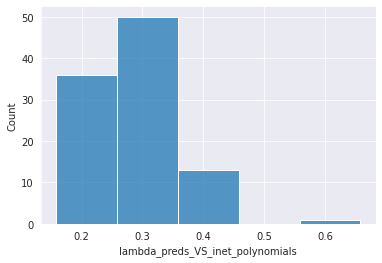

In [44]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

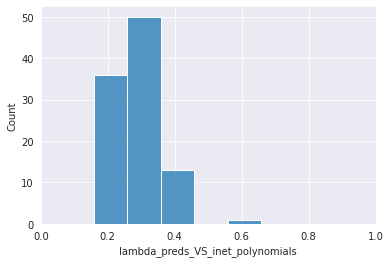

In [45]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


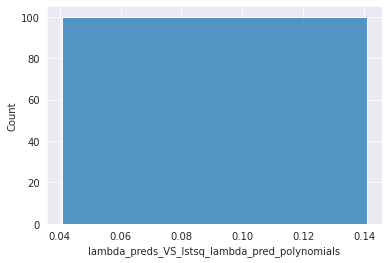

In [46]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
#p.set(xlim=(0, 20))


[(0.0, 1.0)]

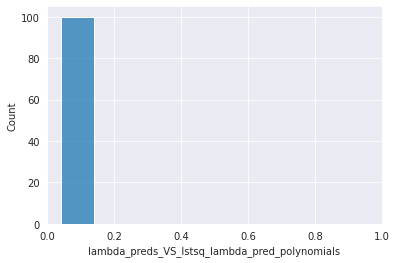

In [47]:
p = sns.histplot(distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'][distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_lstsq_lambda_pred_polynomials'] < 50], binwidth=0.1)
p.set(xlim=(0, 1))


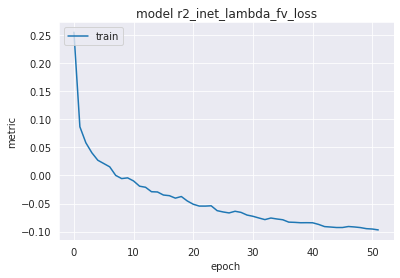

In [48]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


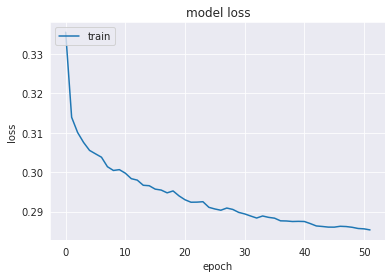

In [49]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [50]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [51]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [52]:
if len(scores_test_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [53]:
index = 6

custom_representation_keys_fixed = ['target_polynomials', 'lstsq_target_polynomials', 'lstsq_lambda_pred_polynomials', 'lstsq_lambda_pred_polynomials']
custom_representation_keys_dynamic = ['inet_polynomials', 'per_network_polynomials']
sympy_representation_keys = ['metamodel_functions']


print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

for key in polynomial_dict_test_list[-1].keys():
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print(key)
    if key in custom_representation_keys_fixed:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], force_complete_poly_representation=True, round_digits=4)
        print(polynomial_dict_test_list[-1][key][index])
    elif key in custom_representation_keys_dynamic:
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], round_digits=4)
        print(polynomial_dict_test_list[-1][key][index])
    else:
        display(polynomial_dict_test_list[-1][key][index])

print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lstsq_lambda_pred_polynomials


0.0785*a**3 - 0.2081*a**2*b - 0.0895*a**2*c - 0.0568*a**2*d + 0.0057*a**2*e + 0.0566*a**2*f - 0.0158*a**2*g - 0.0732*a**2*h - 0.0419*a**2*i + 0.0222*a**2*j - 0.0721*a**2*k + 0.0402*a**2*l - 0.0344*a**2*m + 0.0291*a**2*n - 0.0242*a**2*o + 0.0725*a**2 + 0.1431*a*b**2 + 0.0962*a*b*c + 0.0175*a*b*d - 0.1029*a*b*e + 0.1545*a*b*f - 0.1947*a*b*g + 0.1159*a*b*h - 0.1263*a*b*i - 0.0549*a*b*j + 0.2317*a*b*k - 0.1055*a*b*l + 0.2496*a*b*m - 0.1073*a*b*n - 0.0774*a*b*o + 0.0475*a*b + 0.0607*a*c**2 + 0.0904*a*c*d + 0.0487*a*c*e - 0.2403*a*c*f + 0.0694*a*c*g - 0.1088*a*c*h - 0.0492*a*c*i + 0.06*a*c*j + 0.1045*a*c*k + 0.0166*a*c*l + 0.0646*a*c*m + 0.0234*a*c*n + 0.1137*a*c*o - 0.058*a*c + 0.0474*a*d**2 - 0.0653*a*d*e - 0.1483*a*d*f + 0.0573*a*d*g + 0.1017*a*d*h + 0.0117*a*d*i - 0.0118*a*d*j + 0.0763*a*d*k + 0.0275*a*d*l + 0.0168*a*d*m - 0.0186*a*d*n - 0.0472*a*d*o + 0.1582*a*d - 0.0838*a*e**2 - 0.0339*a*e*f - 0.1955*a*e*g - 0.0728*a*e*h + 0.0818*a*e*i - 0.0677*a*e*j - 0.1453*a*e*k + 0.1226*a*e*l - 0.2

[ 7.85035167e-02 -2.08141298e-01 -8.95104089e-02 -5.67809031e-02
  5.74767790e-03  5.65823100e-02 -1.57751256e-02 -7.31713759e-02
 -4.18631620e-02  2.22313990e-02 -7.21016187e-02  4.01620849e-02
 -3.43670630e-02  2.90842202e-02 -2.42146724e-02  7.24877900e-02
  1.43119122e-01  9.61845405e-02  1.75034393e-02 -1.02924401e-01
  1.54539863e-01 -1.94680344e-01  1.15903029e-01 -1.26313787e-01
 -5.48625840e-02  2.31695974e-01 -1.05502945e-01  2.49634976e-01
 -1.07318250e-01 -7.73856835e-02  4.74589375e-02  6.06928204e-02
  9.03886014e-02  4.86774790e-02 -2.40270570e-01  6.93605622e-02
 -1.08809699e-01 -4.92408015e-02  6.00426400e-02  1.04464177e-01
  1.65982480e-02  6.46133033e-02  2.34108362e-02  1.13706275e-01
 -5.80286636e-02  4.74459671e-02 -6.53101981e-02 -1.48335562e-01
  5.72590551e-02  1.01685552e-01  1.17068979e-02 -1.17779135e-02
  7.62597857e-02  2.75137380e-02  1.67878130e-02 -1.85969977e-02
 -4.71753266e-02  1.58247759e-01 -8.37677808e-02 -3.39145043e-02
 -1.95497172e-01 -7.28154

-0.0497*a**2*g + 0.5033*a*d*o + 0.1021*a*h*o - 0.0116*a*o - 0.3208*b*c*m + 0.8735*b*m**2 + 0.9624*d*g*i - 0.4182*e*f**2 + 0.9361*e*h*l - 0.5241*f**2*g - 0.9139*f*g**2 - 0.7014*f*g*n - 0.7036*f*i*l - 0.2868*j**2*l + 0.784*n*o

[ 3.63949157e-08  3.42361112e-08 -7.61313988e-09  8.83253818e-08
  4.73295019e-08  3.39259404e-08 -4.97362500e-02  3.99448351e-08
  6.14818992e-08  7.40881454e-08 -7.55189804e-09  6.14263630e-08
  1.43672557e-08  7.26182047e-08  6.12596172e-08 -3.07847743e-07
  9.33261925e-08  3.83203544e-08  5.27702058e-09  6.89824033e-09
 -6.20586314e-08 -2.99408742e-09 -7.74857880e-08 -3.30859956e-08
  2.99056024e-08 -3.34211104e-08  2.42061106e-08 -7.43551542e-08
  7.92423637e-08 -2.97511049e-08 -6.44942831e-08  8.83786139e-08
 -9.42597653e-08  1.47768552e-08 -3.66800372e-08  2.61196049e-08
 -1.68714586e-08 -2.48555320e-09 -4.09884426e-08  5.01921732e-08
  1.22870817e-08 -3.15106447e-08  1.00086619e-08 -1.36747492e-07
  1.29658858e-08 -4.67454493e-08  1.95394764e-08  1.00702726e-07
  8.45886884e-08 -9.66361587e-08  1.12998825e-08  7.18562443e-08
 -7.86848764e-08  2.57647933e-08  8.48101626e-08 -4.35674639e-08
  5.03280323e-01 -4.69594419e-08 -2.24161180e-08  1.06032594e-07
  5.94722481e-08 -3.09124

-0.0497*a**2*g + 0.5033*a*d*o + 0.1021*a*h*o - 0.0116*a*o - 0.3208*b*c*m + 0.8735*b*m**2 + 0.9624*d*g*i - 0.4182*e*f**2 + 0.9361*e*h*l - 0.5241*f**2*g - 0.9139*f*g**2 - 0.7014*f*g*n - 0.7036*f*i*l - 0.2868*j**2*l + 0.784*n*o

[ 0.          0.          0.          0.          0.          0.
 -0.04973622  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.50328032  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         

-0.00549999997019768*a*f*k - 0.0599999986588955*c**2*l + 0.161200001835823*c*e*f - 0.00359999993816018*c*h**2 + 0.0272000003606081*c*h*n + 0.187700003385544*d*e*h + 0.0883999988436699*d*j + 0.00579999992623925*d*n*o - 0.0989999994635582*d*n + 0.0900000035762787*e*l*m - 0.335799992084503*g*h*m + 0.0992999970912933*i**3 + 0.159199997782707*i**2 - 0.045099999755621*j*l*n + 0.0533000007271767*k**2

[-0.00362387  0.09925599 -0.00554981 ...  0.00126044  0.00120928
  0.00122257]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


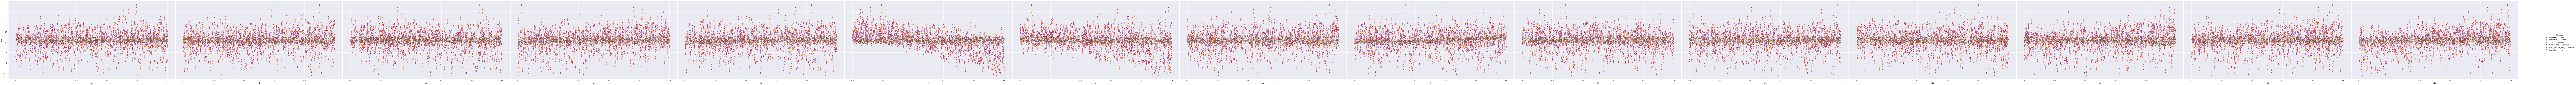

In [54]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

In [55]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

LinAlgError: Singular matrix

ValueError: 'bboxes' cannot be empty

<Figure size 0x0 with 256 Axes>

In [ ]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      polynomial_dict_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

In [ ]:
STOP

# BENCHMARK (RANDOM GUESS) EVALUATION

In [ ]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [ ]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

In [ ]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

In [ ]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [ ]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [ ]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

In [ ]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [ ]:
lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
current_jobs = 1

lr=0.5
max_steps = 100
early_stopping=10
restarts=2
per_network_dataset_size = 500

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

if n_jobs != -1:
    n_jobs_per_network = min(n_jobs, os.cpu_count() // current_jobs)
else: 
    n_jobs_per_network = os.cpu_count() // current_jobs - 1

printing = True if n_jobs_per_network == 1 else False


lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
if evaluate_with_real_function: #target polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.target_polynomial_list)
else: #lstsq lambda pred polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list)


config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }


lambda_network_weights = lambda_network_weights_list[0]
poly_representation = poly_representation_list[0]



per_network_poly_optimization_tf(per_network_dataset_size, 
                                lambda_network_weights, 
                                  list_of_monomial_identifiers_numbers, 
                                  config, 
                                  lr=lr, 
                                  max_steps = max_steps, 
                                  early_stopping=early_stopping, 
                                  restarts=restarts, 
                                  printing=True)


# Evaluate Real Dataset


##  Auto MPG-Dataset

In [ ]:
interpretation_possible_autoMPG = False
print_head_autoMPG = None

url_autoMPG = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names_autoMPG = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset_autoMPG = pd.read_csv(url_autoMPG, names=column_names_autoMPG,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset_autoMPG = raw_dataset_autoMPG.dropna()

dataset_autoMPG['Origin'] = dataset_autoMPG['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset_autoMPG = pd.get_dummies(dataset_autoMPG, columns=['Origin'], prefix='', prefix_sep='')


features_autoMPG = dataset_autoMPG.copy()

labels_autoMPG = features_autoMPG.pop('MPG')

features_autoMPG_normalized = (features_autoMPG-features_autoMPG.min())/(features_autoMPG.max()-features_autoMPG.min())

#labels_autoMPG = (labels_autoMPG-labels_autoMPG.min())/(labels_autoMPG.max()-labels_autoMPG.min())


if features_autoMPG_normalized.shape[1] >= n:
    if n == 1:
        features_autoMPG_model = features_autoMPG_normalized[['Horsepower']]
    elif n == features_autoMPG_normalized.shape[1]:
        features_autoMPG_model = features_autoMPG_normalized
    else:
        features_autoMPG_model = features_autoMPG_normalized.sample(n=n, axis='columns')
        
    print_head_autoMPG = features_autoMPG_model.head()
    interpretation_possible_autoMPG = True

print_head_autoMPG

In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    ((lambda_index_autoMPG, 
     current_seed_autoMPG, 
     polynomial_autoMPG, 
     polynomial_lstsq_pred_list_autoMPG, 
     polynomial_lstsq_true_list_autoMPG), 
    scores_list_autoMPG, 
    pred_list_autoMPG, 
    history_autoMPG, 
    model_autoMPG) = train_nn(lambda_index=0, 
                              X_data_lambda=features_autoMPG_model.values, 
                              y_data_real_lambda=labels_autoMPG.values, 
                              polynomial=None, 
                              seed_list=[RANDOM_SEED], 
                              callbacks=[PlotLossesKerasTF()], 
                              return_history=True, 
                              each_epochs_save=None, 
                              printing=False, 
                              return_model=True)
    
    polynomial_lstsq_pred_autoMPG = polynomial_lstsq_pred_list_autoMPG[-1]

In [ ]:
if interpretation_possible_autoMPG and n==1:
    x = tf.linspace(0.0, 250, 251)
    y = model_autoMPG.predict(x)

    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
config = {
        'n': n,
        'd': d,
        'inet_loss': inet_loss,
        'sparsity': sparsity,
        'lambda_network_layers': lambda_network_layers,
        'interpretation_net_output_shape': interpretation_net_output_shape,
        'RANDOM_SEED': RANDOM_SEED,
        'nas': nas,
        'number_of_lambda_weights': number_of_lambda_weights,
        'interpretation_net_output_monomials': interpretation_net_output_monomials,
        'fixed_initialization_lambda_training': fixed_initialization_lambda_training,
        'dropout': dropout,
        'lambda_network_layers': lambda_network_layers,
        'optimizer_lambda': optimizer_lambda,
        'loss_lambda': loss_lambda,        
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }

weights_autoMPG = model_autoMPG.get_weights()

weights_flat_autoMPG = []
for layer_weights, biases in pairwise(weights_autoMPG):    #clf.get_weights()
    for neuron in layer_weights:
        for weight in neuron:
            weights_flat_autoMPG.append(weight)
    for bias in biases:
        weights_flat_autoMPG.append(bias)
        
weights_flat_autoMPG = np.array(weights_flat_autoMPG)


x = pred_list_autoMPG['X_test_lambda']
y = pred_list_autoMPG['y_test_real_lambda']

y_model_autoMPG = model_autoMPG.predict(x)




In [ ]:
if interpretation_possible_autoMPG:
    y_polynomial_lstsq_pred_autoMPG = calculate_function_values_from_polynomial(polynomial_lstsq_pred_autoMPG, x, force_complete_poly_representation=True)

    mae_model_polynomial_lstsq_pred_autoMPGy = mean_absolute_error(y_model_autoMPG, y_polynomial_lstsq_pred_autoMPG)
    mae_data_polynomial_lstsq_pred_autoMPG = mean_absolute_error(y, y_polynomial_lstsq_pred_autoMPG)

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQt Poly:')
    print_polynomial_from_coefficients(y_polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('MAE Model: ', mae_model_polynomial_lstsq_pred_autoMPGy)
    print('MAE Data: ', mae_data_polynomial_lstsq_pred_autoMPG)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    interpretation_net = model_list[-1]
    
    start = time.time() 
    
    #interpretation_net_poly = interpretation_net.predict(np.array([weights_flat_autoMPG]))[0]
    interpretation_net_poly = make_inet_prediction(interpretation_net, weights_flat_autoMPG, network_data=None, lambda_trained_normalized=False, inet_training_normalized=normalize_inet_data, normalization_parameter_dict=None)
    
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_interpretation_net_poly = calculate_function_values_from_polynomial(interpretation_net_poly, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_interpretation_net_poly)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_interpretation_net_poly)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)    
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:

    start = time.time() 
    
    if False:
        per_network_hyperparams = {
            'optimizer':  'Powell',
            'jac': 'fprime',
            'max_steps': 5000,#100,
            'restarts': 3,
            'per_network_dataset_size': 500,
        }      
        
        per_network_function =  per_network_poly_optimization_scipy(per_network_dataset_size, 
                                                                  weights_flat_autoMPG, 
                                                                  list_of_monomial_identifiers_numbers, 
                                                                  config, 
                                                                  optimizer = per_network_hyperparams['optimizer'],
                                                                  jac = per_network_hyperparams['jac'],
                                                                  max_steps = per_network_hyperparams['max_steps'], 
                                                                  restarts=per_network_hyperparams['restarts'], 
                                                                  printing=True,
                                                                  return_error=False)
    else:
        per_network_hyperparams = {
            'optimizer': tf.keras.optimizers.RMSprop,
            'lr': 0.02,
            'max_steps': 500,
            'early_stopping': 10,
            'restarts': 3,
            'per_network_dataset_size': 5000,
        }   
        
        per_network_function =  per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                              weights_flat_autoMPG, 
                                                              list_of_monomial_identifiers_numbers, 
                                                              config, 
                                                              optimizer = per_network_hyperparams['optimizer'],
                                                              lr=per_network_hyperparams['lr'], 
                                                              max_steps = per_network_hyperparams['max_steps'], 
                                                              early_stopping=per_network_hyperparams['early_stopping'], 
                                                              restarts=per_network_hyperparams['restarts'], 
                                                              printing=True,
                                                              return_error=False)
            
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)  
    
    y_per_network_function = calculate_function_values_from_polynomial(per_network_function, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_per_network_function)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_per_network_function)    
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)       
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    
    symbolic_regression_hyperparams = {
        'dataset_size': 500,
    }

    start = time.time() 
    
    symbolic_regression_function =  symbolic_regression(model_autoMPG, 
                                                      config,
                                                      symbolic_regression_hyperparams,
                                                      #printing = True,
                                                      return_error = False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    variable_names = ['X' + str(i) for i in range(n)]
    
    y_symbolic_regression_function = calculate_function_values_from_sympy(symbolic_regression_function, x, variable_names=variable_names)
    
    mae_model_symbolic_regression_function = mean_absolute_error(y_model_autoMPG, y_symbolic_regression_function)
    mae_data_symbolic_regression_function = mean_absolute_error(y, y_symbolic_regression_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Poly:')    
    display(symbolic_regression_function)
    print('MAE Model: ', mae_model_symbolic_regression_function)
    print('MAE Data: ', mae_data_symbolic_regression_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG and True:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = False,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function = calculate_function_values_from_sympy(metamodel_function, x)
    
    mae_model_metamodel_function = mean_absolute_error(y_model_autoMPG, y_metamodel_function)
    mae_data_metamodel_function = mean_absolute_error(y, y_metamodel_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')    
    display(metamodel_function)
    print('MAE Model: ', mae_model_metamodel_function)
    print('MAE Data: ', mae_data_metamodel_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG and False:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function_basic =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = True,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function_basic = calculate_function_values_from_sympy(metamodel_function_basic, x)
    
    mae_metamodel_function_basic = mean_absolute_error(y_model_autoMPG, y_metamodel_function_basic)
    mae_metamodel_function_basic = mean_absolute_error(y, y_metamodel_function_basic)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function Basic:')    
    display(metamodel_function_basic)
    print('MAE Model: ', mae_metamodel_function_basic)
    print('MAE Data: ', mae_metamodel_function_basic)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQ Poly:')
    print_polynomial_from_coefficients(polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Function:')
    display(symbolic_regression_function)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')
    display(metamodel_function)
    #print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    #print('Metamodel Function Basic:')
    #display(metamodel_function_basic)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
if interpretation_possible_autoMPG and n==1:
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    
    ax.set_ylim([0,50])
    
    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.scatter(x, y, label='Test Data')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_model_autoMPG))]) , label='Model Predictions')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_interpretation_net_poly))]) , label='Interpretation Net Poly')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_per_network_function))]) , label='Per Network Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_polynomial_lstsq_pred_autoMPG))]) , label='LSTSQ Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_symbolic_regression_function))]) , label='Symbolic Regression Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_metamodel_function))]) , label='Metamodel Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y))]) y_metamodel_function_basic, label='Metamodel Function Basic')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
sample_data_X = np.array([i for i in range(1000)])
sample_data_y = np.array([3*i for i in range(1000)])

current_seed = 42

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y*1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y+1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:


model_2_weights = model.get_weights()
model_2_normalized_weights = model_2_weights #[weights/10 for weights in model_2_weights]


model_2_normalized_weights[-6] = model_2_normalized_weights[-6]/10
model_2_normalized_weights[-5] = model_2_normalized_weights[-5]/10

model_2_normalized_weights[-4] = model_2_normalized_weights[-4]/10
model_2_normalized_weights[-3] = model_2_normalized_weights[-3]/100

model_2_normalized_weights[-2] = model_2_normalized_weights[-2]/10
model_2_normalized_weights[-1] = model_2_normalized_weights[-1]/1000

model_2.set_weights(model_2_normalized_weights)

print(model_2.get_weights())
print(model_2.predict([1, 10]))

# Evaluate Per-Network Poly Optimization

## Example Optimization (Common Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer':  'Powell',
    'jac': 'fprime',
    'max_steps': 5000,#100,
    'restarts': 3,
    'per_network_dataset_size': 500,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_scipy(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      jac = per_network_hyperparams['jac'],
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Example Optimization (Neural Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer': tf.keras.optimizers.RMSprop,
    'lr': 0.02,
    'max_steps': 500,
    'early_stopping': 10,
    'restarts': 3,
    'per_network_dataset_size': 5000,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      lr = per_network_hyperparams['lr'], 
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      early_stopping = per_network_hyperparams['early_stopping'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error.numpy()))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Grid Search Common Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 10

per_network_hyperparams = {
    'optimizer':  [
                   'Nelder-Mead', 
                   'Powell', 
        
                   'CG',
                   'BFGS',
                   'Newton-CG', 
                   #'L-BFGS-B', #'>' not supported between instances of 'int' and 'NoneType'
                   'TNC', 
                   
                   'COBYLA', 
                   'SLSQP', 
                   
                   #'trust-constr', # TypeError: _minimize_trustregion_constr() got an unexpected keyword argument 'maxfun'
                   #'dogleg', # ValueError: Hessian is required for dogleg minimization
                   #'trust-ncg', #ValueError: Either the Hessian or the Hessian-vector product is required for Newton-CG trust-region minimization
                   #'trust-exact', # ValueError: Hessian matrix is required for trust region exact minimization.
                   #'trust-krylov' #ValueError: Either the Hessian or the Hessian-vector product is required for Krylov trust-region minimization
                   ], 
    'jac': ['fprime'],
    'max_steps': [5000],#100,
    'restarts': [3],
    'per_network_dataset_size': [500],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_scipy)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  jac = params['jac'],
                                                                                  max_steps = params['max_steps'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

## Grid Search Neural Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 100

per_network_hyperparams = {
    'optimizer': [tf.keras.optimizers.RMSprop], #[tf.keras.optimizers.SGD, tf.optimizers.Adam, tf.keras.optimizers.RMSprop, tf.keras.optimizers.Adadelta]
    'lr': [0.02], #[0.5, 0.25, 0.1, 0.05, 0.025]
    'max_steps': [5000],#100,
    'early_stopping': [10],
    'restarts': [3],
    'per_network_dataset_size': [5000],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_tf)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  lr = params['lr'], 
                                                                                  max_steps = params['max_steps'], 
                                                                                  early_stopping = params['early_stopping'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

In [ ]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()